In [1]:
import numpy as np
from fish.ephys import ephys
from glob import glob

import matplotlib.pyplot as plt
from skimage import io
import os
%matplotlib inline

In [73]:
def axs_format(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
def prepare_swim(swims, threshold=False):
    from numpy import percentile
    from fish.ephys.ephys import windowed_variance, estimate_threshold
    
    swim_flt = [windowed_variance(s, kern_mean=None, kern_var=None)[0] for s in swims]        
    ts = (swim_flt[0] + swim_flt[1])
    ts = ts.clip(max = np.percentile(ts, 99.99))
    ts -= ts.min()
    ts /= ts.max()
    
    if threshold:
        th = estimate_threshold(ts)
        ts[ts < th] = 0
    
    return ts

def prepare_data(fname, fs_ep, fused_roi, do_threshold, meta):
    # load and process ephys data    
    from fish.ephys.ephys import load, chop_trials, windowed_variance
    from scipy.signal import fftconvolve, gaussian
    from numpy import array
    processed = {}
    dat = load(fname)
    swims = dat[0:2].copy()
        
    swims = array([windowed_variance(s)[0] for s in swims])
    laser_signal = dat[6].copy()
    trial_signal = dat[4].copy()
    
    swim_pow = prepare_swim(swims[meta['ch']], threshold=do_threshold)    
    
    kern_smooth = gaussian(2 * fs_ep, 1000)
    kern_smooth /= kern_smooth.sum()
    swim_pow_smooth = fftconvolve(swim_pow, kern_smooth, mode='same')
    processed['fname'] = fname
    processed['laser_signal'] = laser_signal
    processed['trial_signal'] = trial_signal
    processed['swims'] = swims
    processed['swim_power'] = swim_pow
    processed['swim_power_smoothed'] = swim_pow_smooth
        
    laser = chop_trials(laser_signal)
    on_val = max(list(laser.keys()))

    if fused_roi:
        for val in np.arange(2, len(np.unique(trial_signal)), 2):
            trial_signal[trial_signal == val] = val-1
        
    rois = chop_trials(trial_signal)
    conds = [int(x) for x in rois if x > 0]
    processed['stim_dur'] = np.median(rois[1][1] - rois[1][0])
    processed['conds'] = conds
    processed['trials'] = rois

    return processed

In [31]:
pos_dir = '/groups/ahrens/ahrenslab/projects/ngm/ephys/opto/pos/'
neg_dir = '/groups/ahrens/ahrenslab/projects/ngm/ephys/opto/neg/'
proc_dir = '/groups/ahrens/ahrenslab/projects/ngm/ephys/opto/'

if not os.path.exists(proc_dir):
    os.makedirs(proc_dir)

In [83]:
from os.path import split, sep

fnames = {}
fnames['pos'] = glob(pos_dir + '*/*.10chFlt')
fnames['pos'].sort()

fnames['neg'] = glob(neg_dir + '*/*.10chFlt')
fnames['neg'].sort()

#exp_dirs = [split(f)[0] + sep for f in fnames_ep]

for ind, f in enumerate(fnames['pos']):
    print('Pos: {0} : {1}'.format(ind, f.split(os.path.sep)[-1]))
    
for ind, f in enumerate(fnames['neg']):
    print('Neg: {0} : {1}'.format(ind, f.split(os.path.sep)[-1]))

Pos: 0 : 20170316_1_3_gfapcochr_rgeco_g1_6dpf_opto_OMR.10chFlt
Pos: 1 : 20170320_2_6_g1_r1_7dpf_laser65.10chFlt
Pos: 2 : 20170321_1_3_g1_r1_6dpf_laser65_20ms.10chFlt
Pos: 3 : 20170324_7dpf_cy252xcy293_g1_f1_omr_opto_2.10chFlt
Pos: 4 : 20170324_7dpf_cy252xcy293_g1_f2_omr_opto_1.10chFlt
Pos: 5 : 20170324_7dpf_cy252xcy293_g1_f3_omr_opto_2.10chFlt
Pos: 6 : 20170330_6dpf_cy252xcy293_g1_f1_omr_opto_1.10chFlt
Pos: 7 : 20170330_6dpf_cy252xcy293_gx_f2_omr_opto_2_laser6.10chFlt
Pos: 8 : 20170331_f1_g1_7dpf_6.10chFlt
Pos: 9 : 20170404_6dpf_cy252xcy293_f1_g1_omr_opto_1.10chFlt
Pos: 10 : 20170404_6dpf_cy252xcy293_f4_g1_omr_opto_1.10chFlt
Pos: 11 : 20170404_6dpf_cy252xcy293_f5_g1_omr_opto_2.10chFlt
Pos: 12 : 20170404_6dpf_cy252xcy293_f6_g1_omr_opto_2.10chFlt
Pos: 13 : 20170405_7dpf_cy252xcy293_f1_g1_omr_opto_1.10chFlt
Pos: 14 : 20170405_7dpf_cy252xcy293_f2_g1_omr_opto_1.10chFlt
Neg: 0 : 20170319_1_1_g0_r0_6dpf.10chFlt
Neg: 1 : 20170319_2_2_g0_r0_6dpf_laser6.10chFlt
Neg: 2 : 20170322_7dpf_cy252xcy293

# Define a dictionary of dictionaries containing dataset-specific parameters

In [98]:
exp_params = {}

exp_params['20170316_1_3_gfapcochr_rgeco_g1_6dpf_opto_OMR.10chFlt'] = {'ch' : [0,0], 'fs' : 6000}
exp_params['20170320_2_6_g1_r1_7dpf_laser65.10chFlt'] = {'ch' : [0,1], 'fs' : 6000}
exp_params['20170321_1_3_g1_r1_6dpf_laser65_20ms.10chFlt'] = {'ch' : [0,1], 'fs' : 6000}

exp_params['20170324_7dpf_cy252xcy293_g1_f1_omr_opto_2.10chFlt'] = {'ch' : [1,1], 'fs' : 6000}
exp_params['20170324_7dpf_cy252xcy293_g1_f2_omr_opto_1.10chFlt'] = {'ch' : [0,1], 'fs' : 6000}
exp_params['20170324_7dpf_cy252xcy293_g1_f3_omr_opto_2.10chFlt'] = {'ch' : [0,1], 'fs' : 6000}

exp_params['20170330_6dpf_cy252xcy293_g1_f1_omr_opto_1.10chFlt'] = {'ch' : [0,0], 'fs' : 6000}
exp_params['20170330_6dpf_cy252xcy293_gx_f2_omr_opto_2_laser6.10chFlt'] = {'ch' : [0,1], 'fs' : 6000}

exp_params['20170331_f1_g1_7dpf_6.10chFlt'] = {'ch' : [1,1], 'fs' : 6000}

exp_params['20170404_6dpf_cy252xcy293_f1_g1_omr_opto_1.10chFlt'] = {'ch' : [0,1], 'fs' : 6000}
exp_params['20170404_6dpf_cy252xcy293_f4_g1_omr_opto_1.10chFlt'] = {'ch' : [0,1], 'fs' : 6000}
exp_params['20170404_6dpf_cy252xcy293_f5_g1_omr_opto_2.10chFlt'] = {'ch' : [0,1], 'fs' : 6000}
exp_params['20170404_6dpf_cy252xcy293_f6_g1_omr_opto_2.10chFlt'] = {'ch' : [0,1], 'fs' : 6000}

exp_params['20170405_7dpf_cy252xcy293_f1_g1_omr_opto_1.10chFlt'] = {'ch' : [0,1], 'fs' : 6000}
exp_params['20170405_7dpf_cy252xcy293_f2_g1_omr_opto_1.10chFlt'] = {'ch' : [0,1], 'fs' : 6000}
exp_params['20170319_1_1_g0_r0_6dpf.10chFlt'] = {'ch' : [1,1], 'fs' : 6000}
exp_params['20170319_2_2_g0_r0_6dpf_laser6.10chFlt'] = {'ch' : [1,0], 'fs' : 6000}
exp_params['20170322_7dpf_cy252xcy293_g0_f3_omr_opto_2.10chFlt'] = {'ch' : [1,1], 'fs' : 6000}
exp_params['20170406_6dpf_cy252xcy293_f1_g0_omr_opto_1.10chFlt'] = {'ch' : [0,1], 'fs' : 6000}

In [103]:
%%time
prepped = {}
for key, files in fnames.items():
    prepped[key] = []
    for ind, val in enumerate(files):
        expname = val.split(os.path.sep)[-1]
        prepped[key].append(prepare_data(val, fs_ep = exp_params[expname]['fs'], fused_roi = True, do_threshold=True, meta = exp_params[expname]))

Data needed to be truncated!
Data needed to be truncated!
Data needed to be truncated!
CPU times: user 7min 58s, sys: 1min 4s, total: 9min 3s
Wall time: 9min 3s


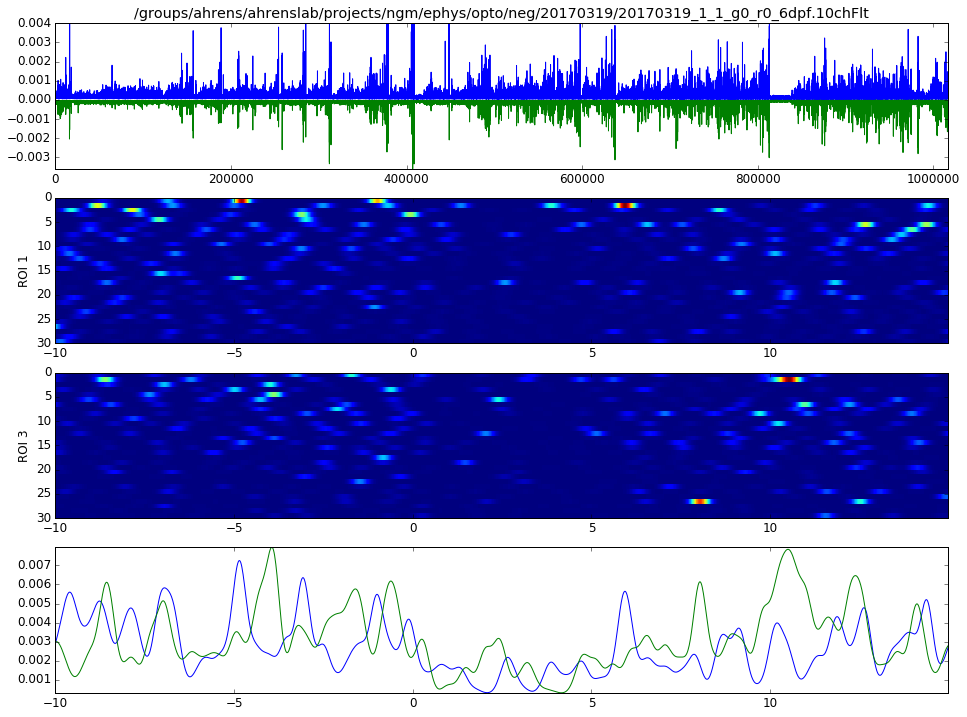

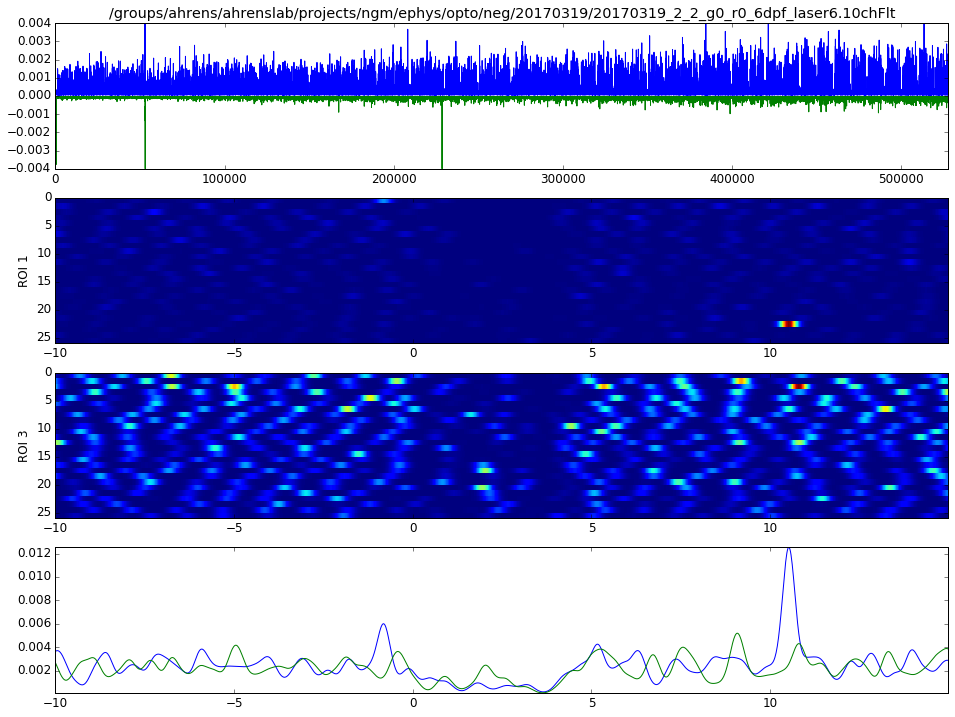

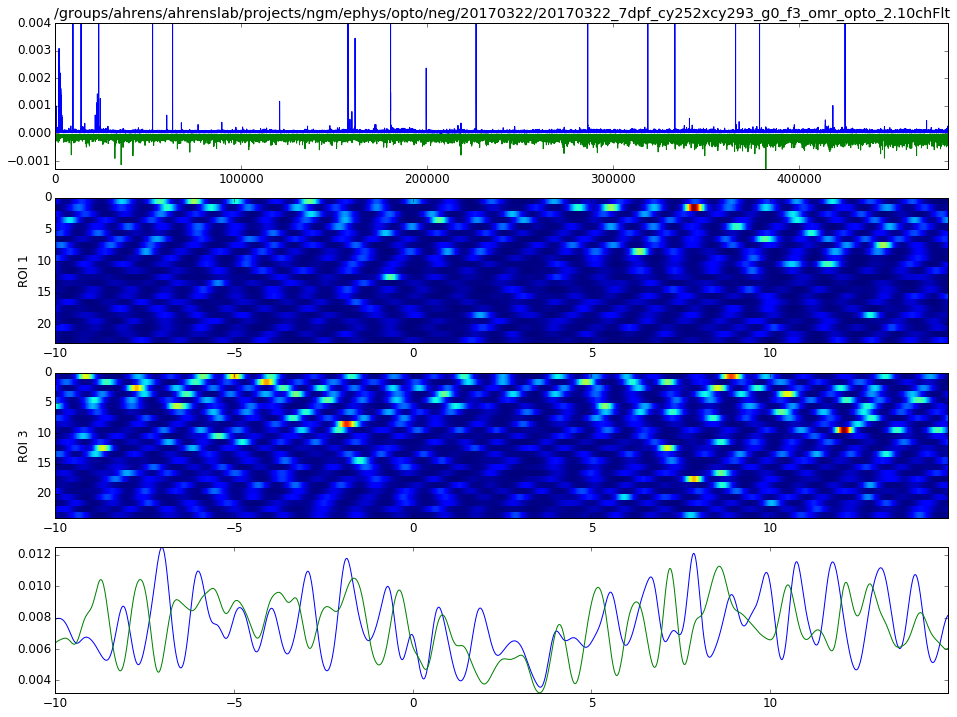

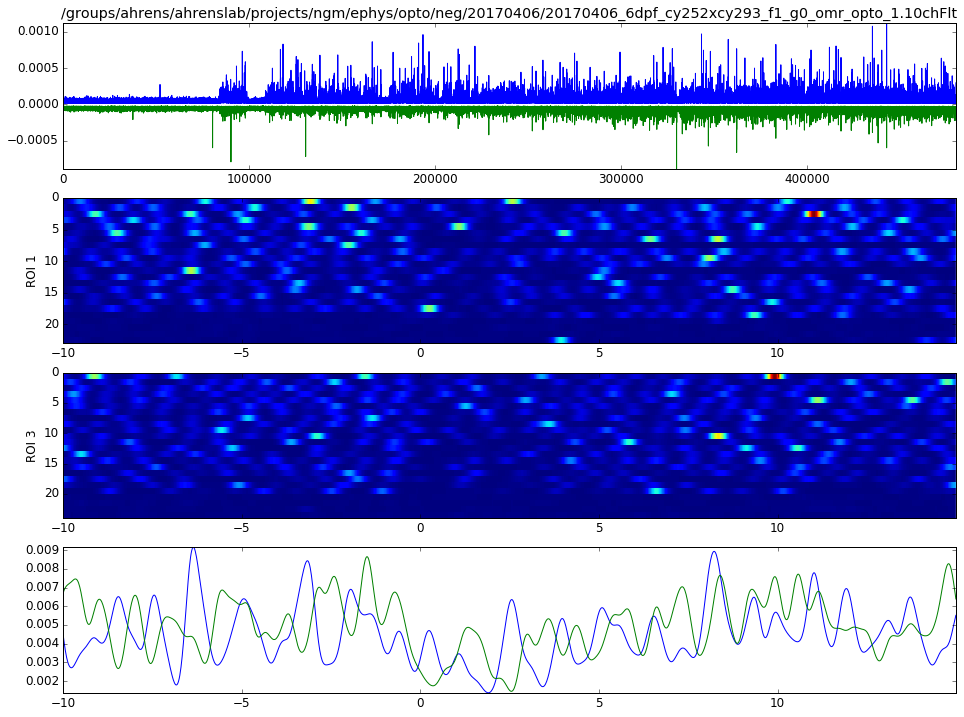

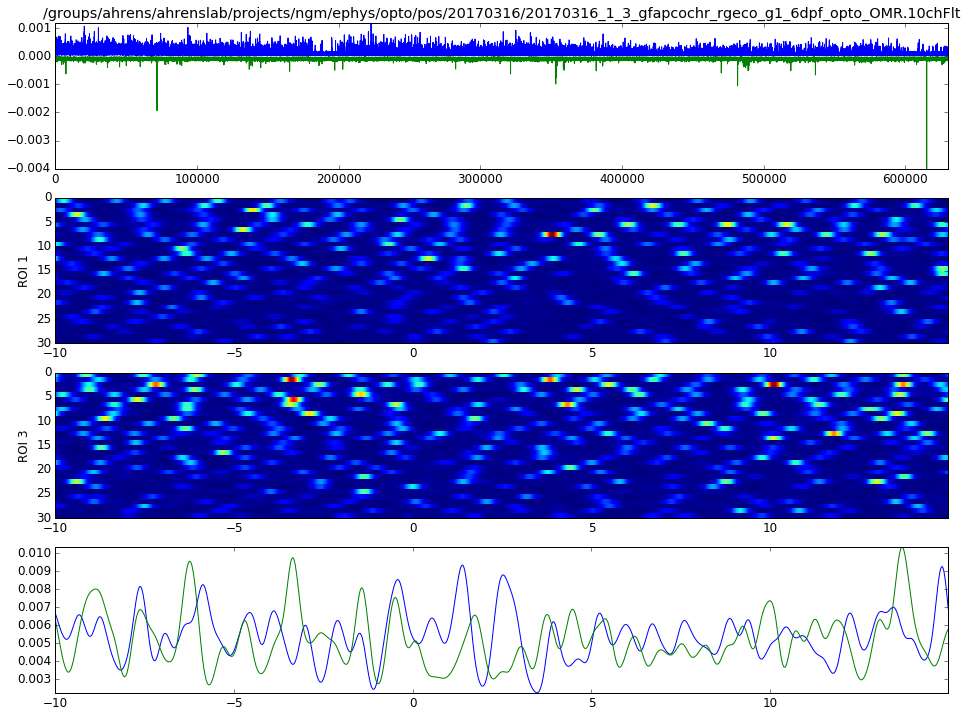

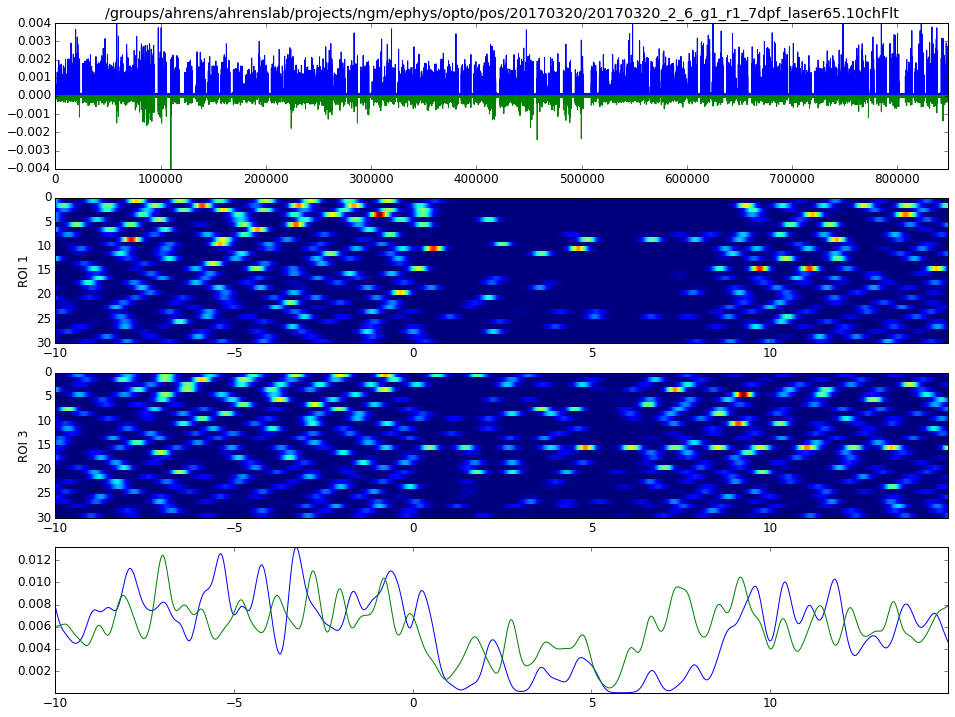

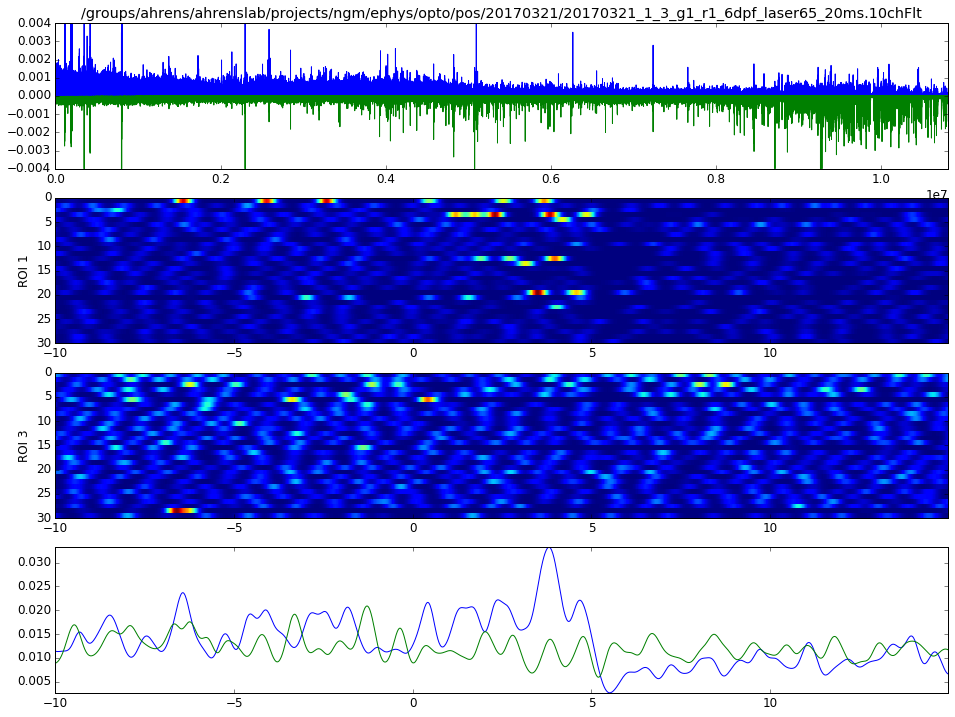

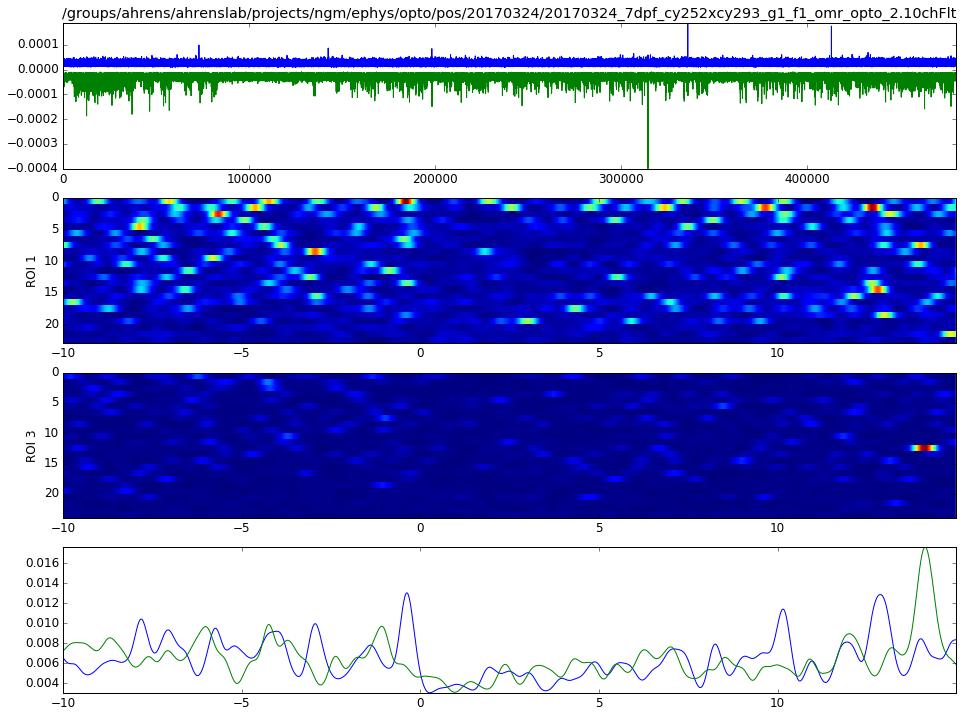

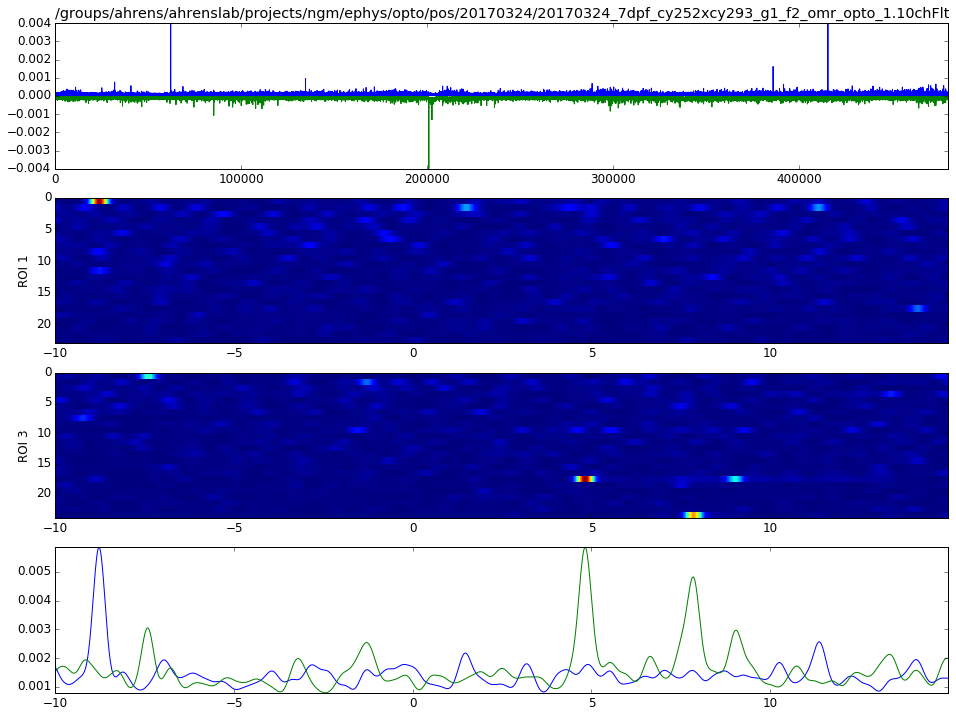

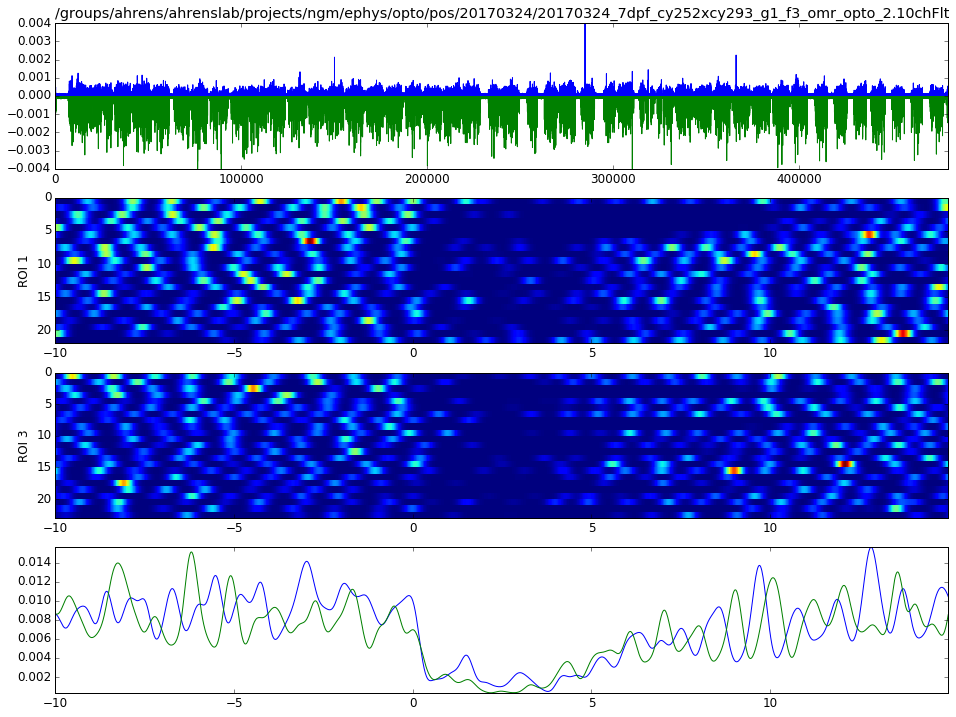

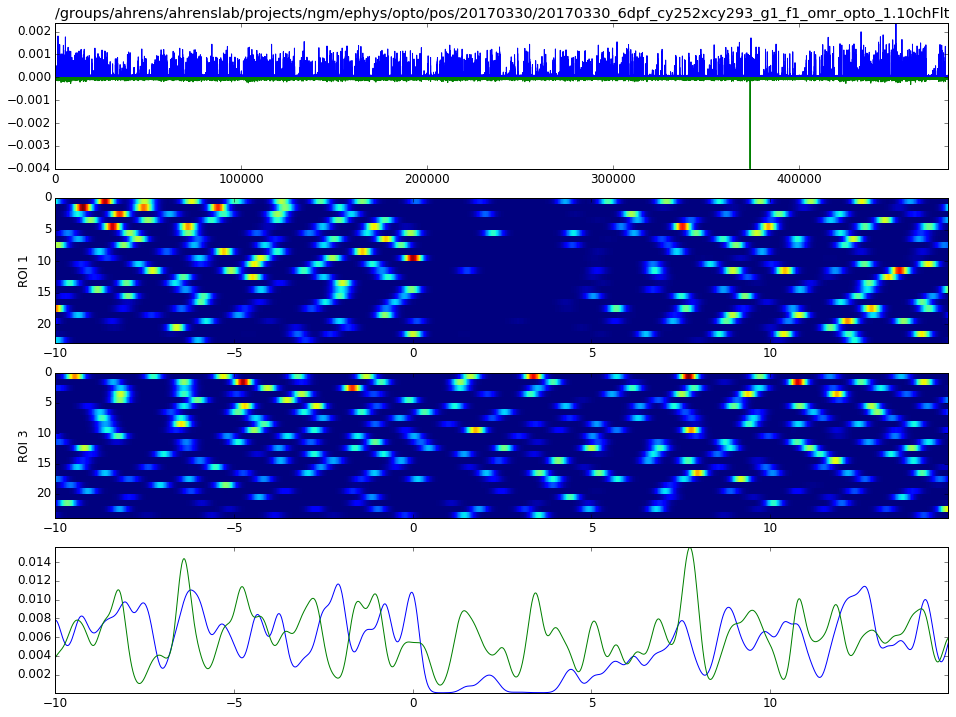

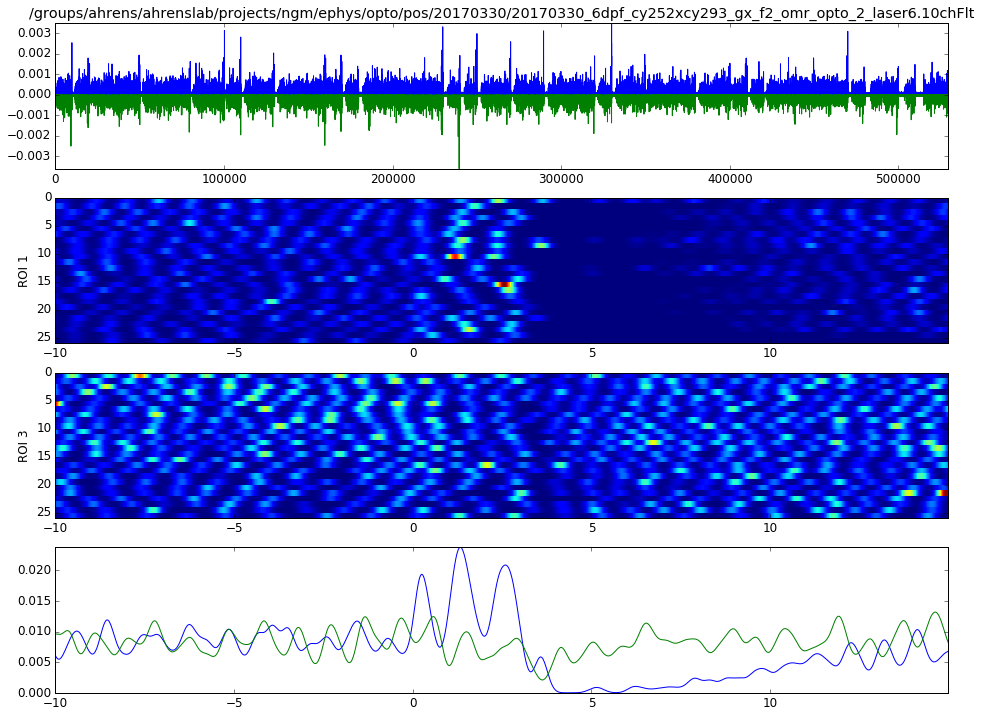

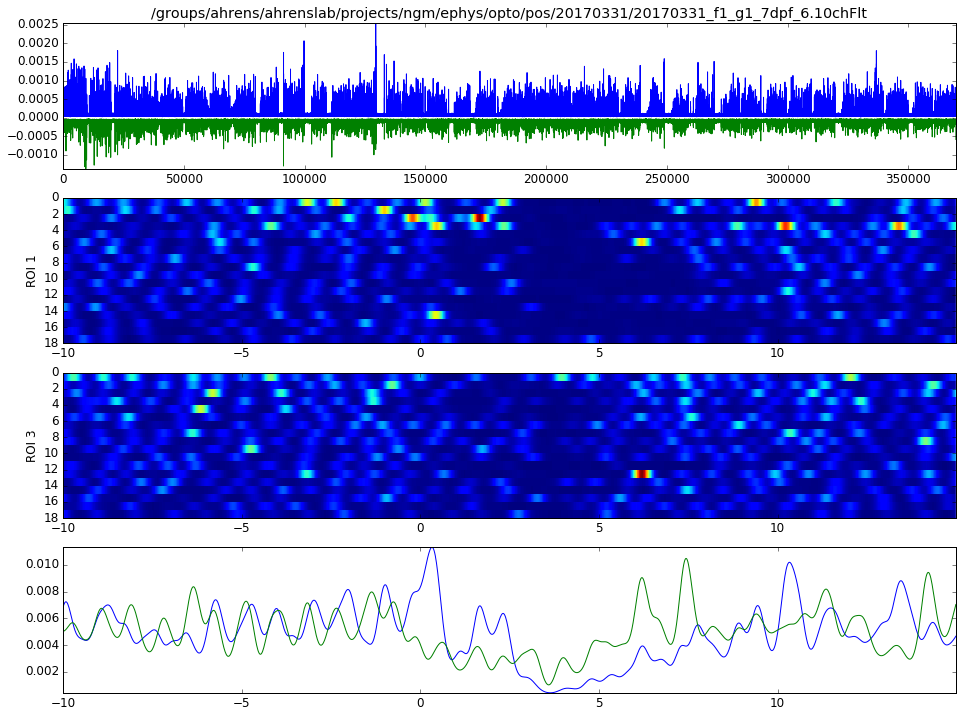

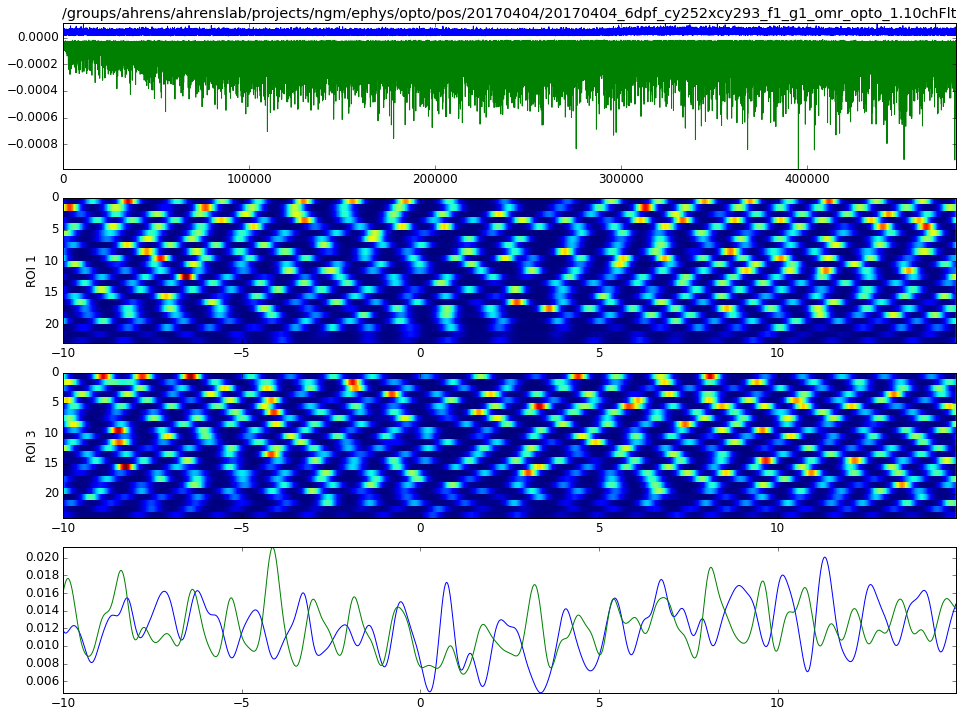

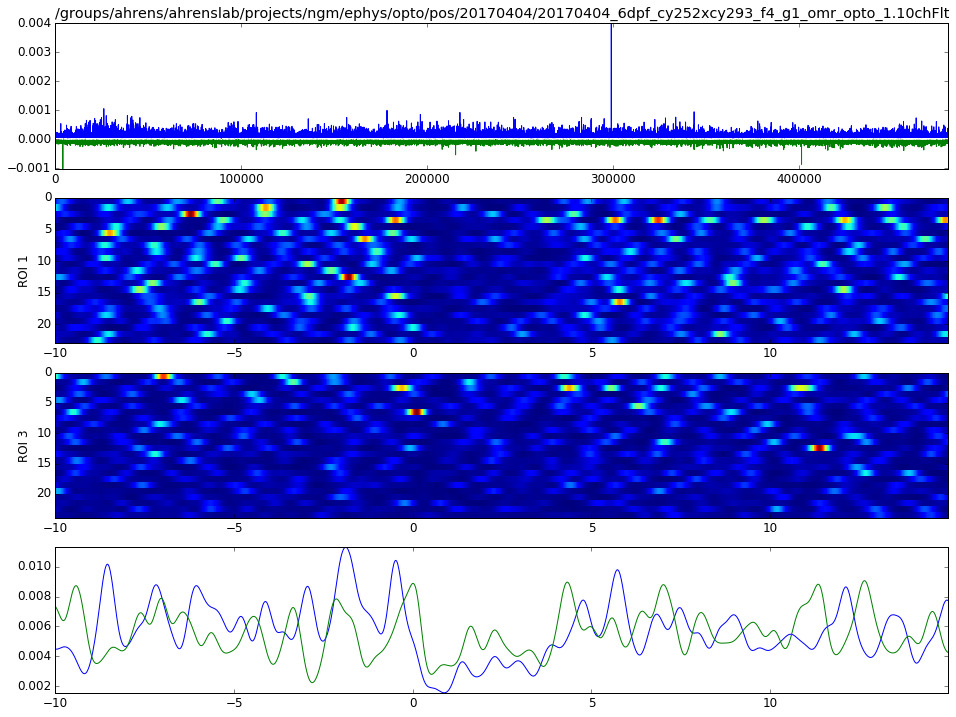

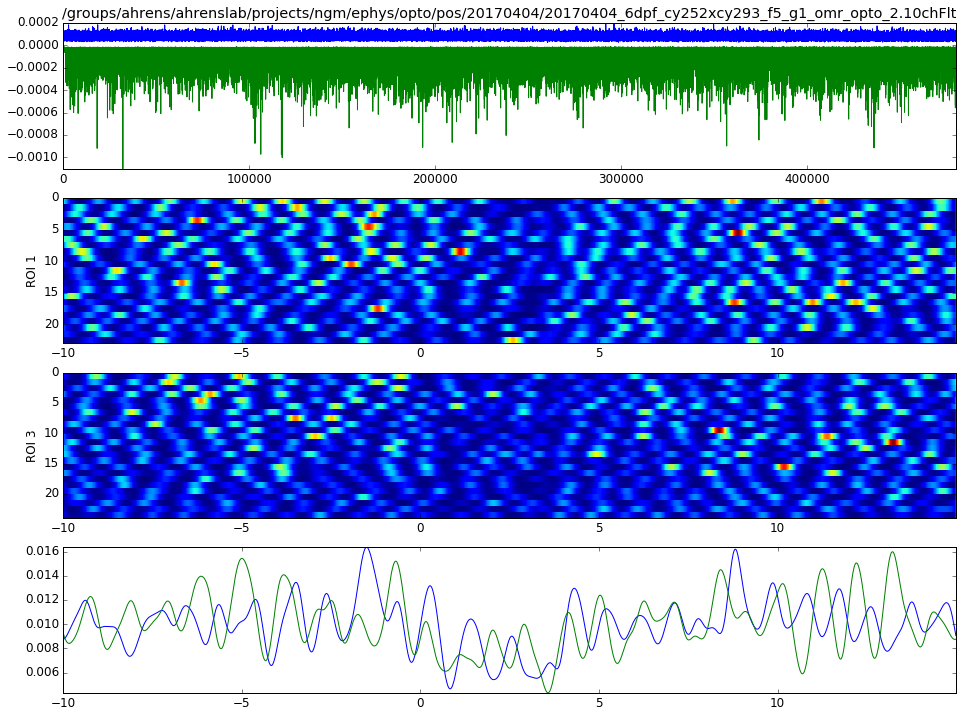

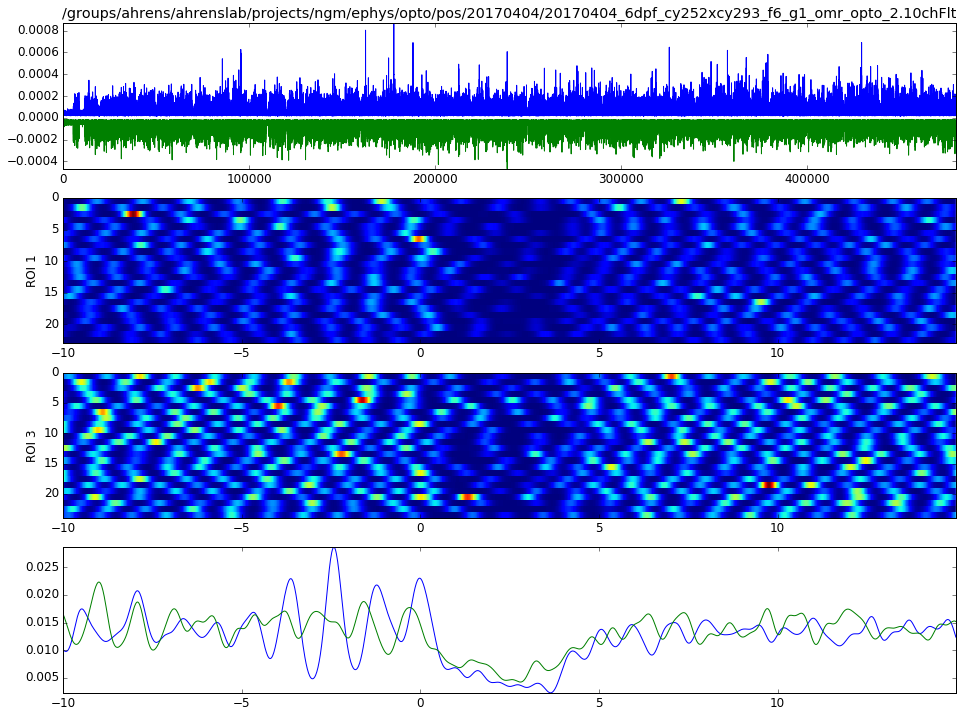

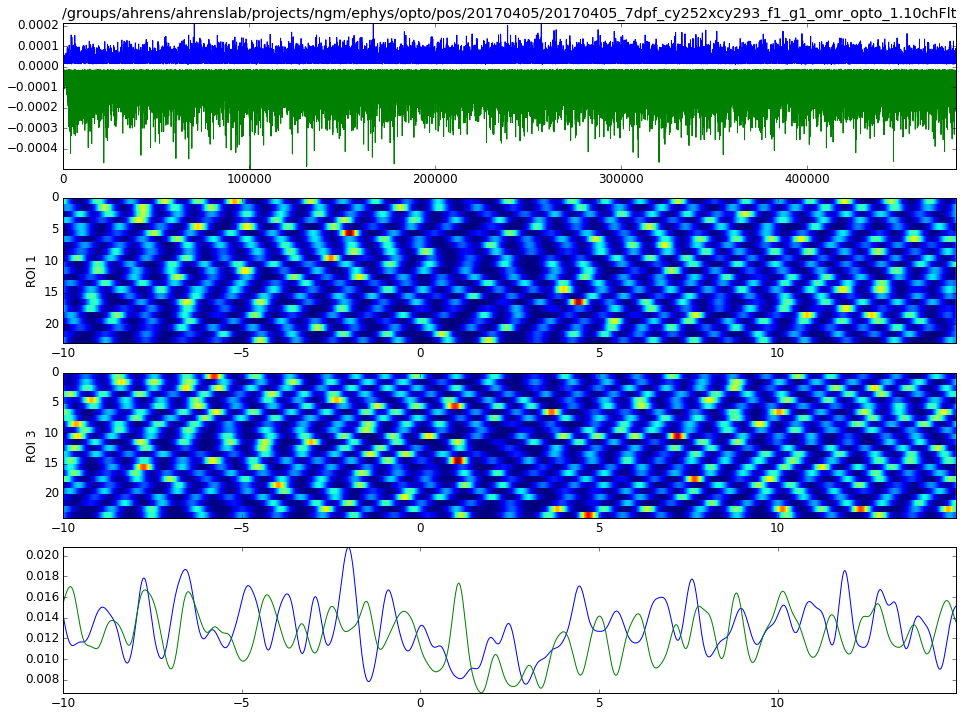

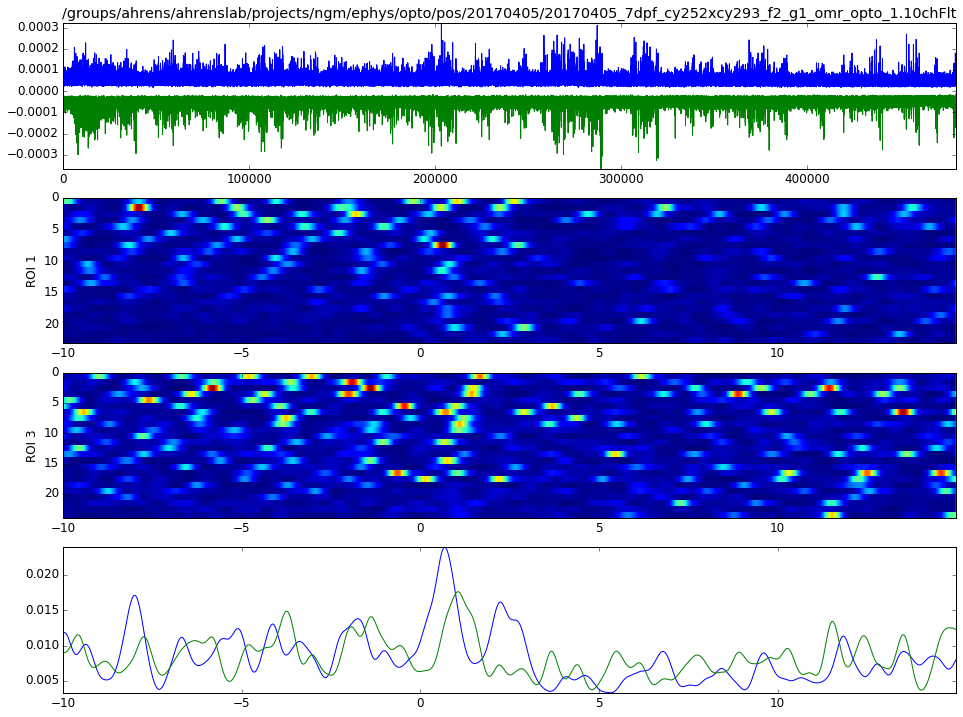

In [104]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
def raster_plot(data, fs_ep, title):  
    to_compare = [1,3]
    fig, axs = plt.subplots(nrows=2 + len(to_compare), figsize=(16,12))
    ds_ep = 100
    window = np.arange(-fs_ep * 10, fs_ep * 15, ds_ep)
    onset = np.where(window >= 0)[0][0]
    
    axs[0].plot(data['swims'][0][::15].clip(0, .004))
    axs[0].plot(-data['swims'][1][::15].clip(0, .004))
    axs[0].axis('tight')    
    #axs[-1].plot(prepped['trial_signal'][trials].mean(0))    
    axs[0].title.set_text(title)
    
    for ind, condition in enumerate(to_compare):    
        trials = np.array([t + window for t in data['trials'][condition][0] if t + window[-1] < len(data['swim_power'])])
        to_plot = data['swim_power_smoothed'][trials]    
                
        # order by swim power before stimulation
        plot_order = np.argsort(to_plot[:,:onset].mean(1))[::-1][slice(0, 30)]        
        to_plot = to_plot[plot_order,:]        
        
        tr_mean = to_plot.mean(0)
        # rescale pre-stimulus swims to mean = 1
        #tr_mean /= tr_mean[:onset].mean()
        
        clims = (to_plot.min(), to_plot.max())
        # plot the whole recording, both channels
        
        axs[1 + ind].imshow(to_plot, cmap='jet', interpolation='None', extent=(window[0] / fs_ep, window[-1] / fs_ep, to_plot.shape[0], 0), aspect='auto', clim=clims)
        axs[1 + ind].set_ylabel('ROI {0}'.format(condition))    
        
        axs[-1].plot(window/ fs_ep, tr_mean)
        axs[-1].axis('tight')

for key, val in prepped.items():
    [raster_plot(p, sampling_rates[ind], p['fname']) for ind, p in enumerate(val)]

In [105]:
%%time

window = np.arange(-6000 * 10, 6000 * 15, 1)

def data_gather(data, fs_ep, window):  
    to_compare = [1,3]    
    to_keep = slice(0, 25)
    onset = np.where(window >= 0)[0][0]
    output_trials = []
    
    for ind, condition in enumerate(to_compare):        
        trials = np.array([t + window for t in data['trials'][condition][0] if t + window[-1] < len(data['swim_power'])])
        sub_data = data['swim_power_smoothed'][trials]    

        # order by swim power before stimulation
        plot_order = np.argsort(sub_data[:,:onset].mean(1))[::-1][to_keep]        
        sub_data = sub_data[plot_order,:]
        output_trials.append(sub_data)
    
    return output_trials

gathered = {}
for key, val in prepped.items():
    gathered[key] = [data_gather(p, sampling_rates[ind], window) for ind, p in enumerate(val)]

CPU times: user 1.62 s, sys: 903 ms, total: 2.52 s
Wall time: 2.52 s


In [106]:
def stack_trials(data):
    import numpy as np
    tstack = {}
    
    tstack['stim'] = []
    tstack['control'] = []
    tstack['stim_fish'] = []
    tstack['control_fish'] = []
    
    for ind, fish in enumerate(data):
        tstack['stim'].append(fish[0])
        tstack['stim_fish'].append(ind + np.zeros([fish[0].shape[0], 1], 'uint8'))
        
        tstack['control'].append(fish[-1])
        tstack['control_fish'].append(ind + np.zeros([fish[-1].shape[0], 1], 'uint8'))
    
    for key, val in tstack.items():
        tstack[key] = np.vstack(np.array(tstack[key]))

    
    return tstack

In [107]:
tstack_pos = stack_trials(gathered['pos'])
tstack_pos['window'] = window
tstack_neg = stack_trials(gathered['neg'])
tstack_neg['window'] = window

In [108]:
save_for_misha = False
if save_for_misha:
    from scipy.io import savemat
    savemat('/groups/ahrens/ahrenslab/projects/ngm/ephys/opto/stacked_trials_pos.mat', tstack_pos)
    savemat('/groups/ahrens/ahrenslab/projects/ngm/ephys/opto/stacked_trials_neg.mat', tstack_neg)

[None, None]

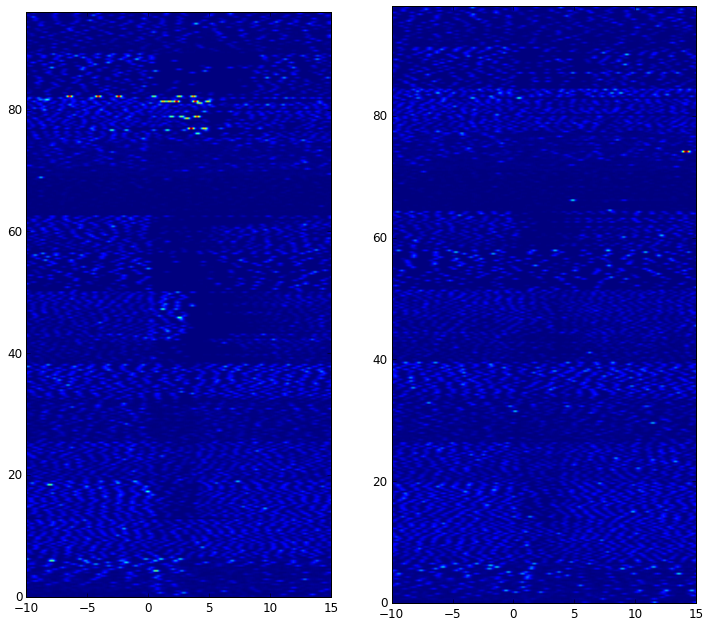

In [109]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,24))
ims = []
ims.append(axs[0].imshow(tstack_pos['stim'], extent = (window[0] / 6000, window[-1] / 6000, 0, tstack_neg['stim'].shape[0]), cmap='jet', aspect=(.5)))
ims.append(axs[1].imshow(tstack_pos['control'], extent = (window[0] / 6000, window[-1] / 6000, 0, tstack_neg['control'].shape[0]), cmap='jet', aspect=(.5)))

clims = np.array([im.get_clim() for im in ims])
[im.set_clim(clims.min(), clims.max()) for im in ims]

In [110]:
def rescale(mat, window):
    # rescale pre-stim to have unitary mean swim power
    onset = np.where(window > 0)[0][0]
    tmp = mat.copy().T
    tmp /= np.median(tmp[:onset], axis=0)
    return tmp.T

In [111]:
tstack_neg_rescaled = {k: rescale(v, window) for k,v in tstack_neg.items() if k in ['control', 'stim']}
tstack_pos_rescaled = {k: rescale(v, window) for k,v in tstack_pos.items() if k in ['control', 'stim']}

[None, None]

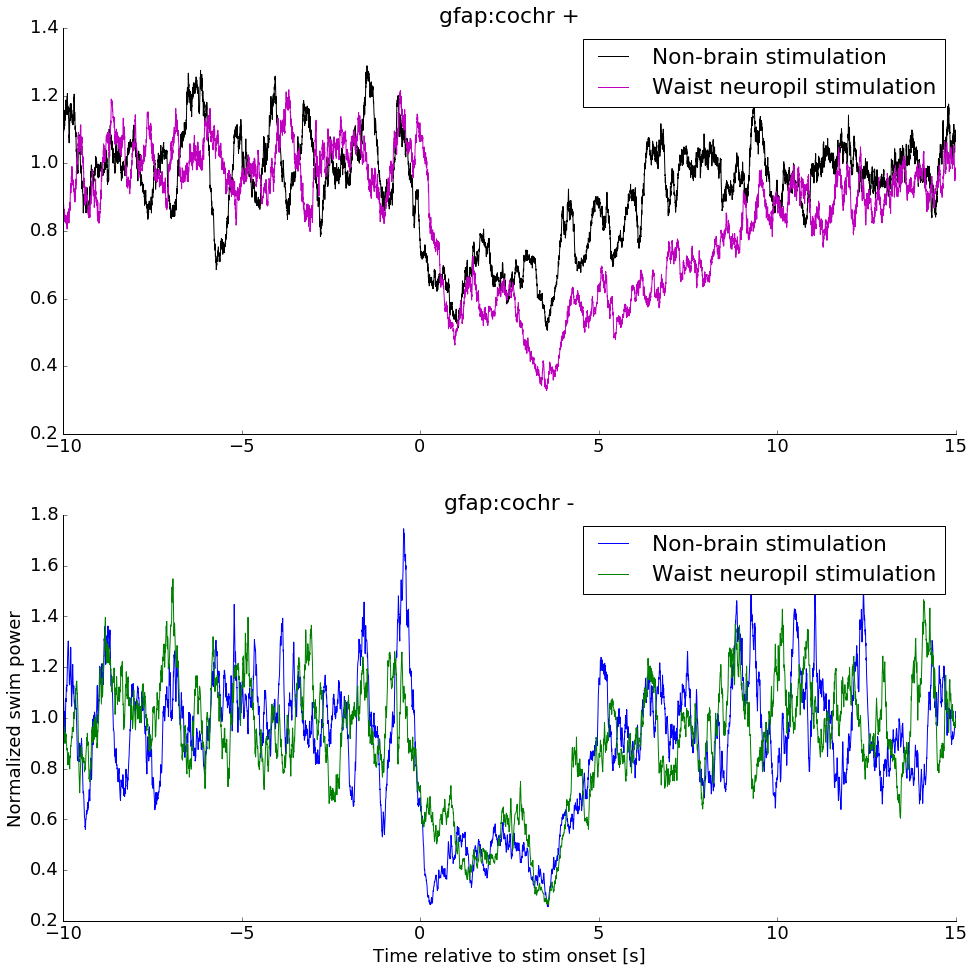

In [117]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
nr = 2
nc = 1
fs_ep = 6000
fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(16 * nc, 8 * nr))
x_axis = window / fs_ep 

axs[0].plot(x_axis, np.median(tstack_pos_rescaled['control'], axis=0), label = 'Non-brain stimulation', color='k')
axs[0].plot(x_axis, np.median(tstack_pos_rescaled['stim'], axis=0), label = 'Waist neuropil stimulation', color='m')
axs[0].title.set_text('gfap:cochr +')
axs[0].legend()

axs[1].plot(x_axis, np.median(tstack_neg_rescaled['control'], axis=0), label = 'Non-brain stimulation')
axs[1].plot(x_axis, np.median(tstack_neg_rescaled['stim'], axis=0), label = 'Waist neuropil stimulation')
axs[1].title.set_text('gfap:cochr -')
axs[1].legend()
axs[-1].set_xlabel('Time relative to stim onset [s]')
axs[-1].set_ylabel('Normalized swim power')
list(map(axs_format, axs))


In [115]:
means = {}
for k, v in gathered.items():    
    means[k] = np.array([[f[0].mean(0), f[1].mean(0)] for f in v])
    
rescaled_means = {}
onset = np.where(window > 0)[0][0]
rescaled_means['pos'] = (means['pos'][:,:,:].T / means['pos'][:,:,:onset].mean(-1).T).T
rescaled_means['neg'] = (means['neg'][:,:,:].T / means['neg'][:,:,:onset].mean(-1).T).T

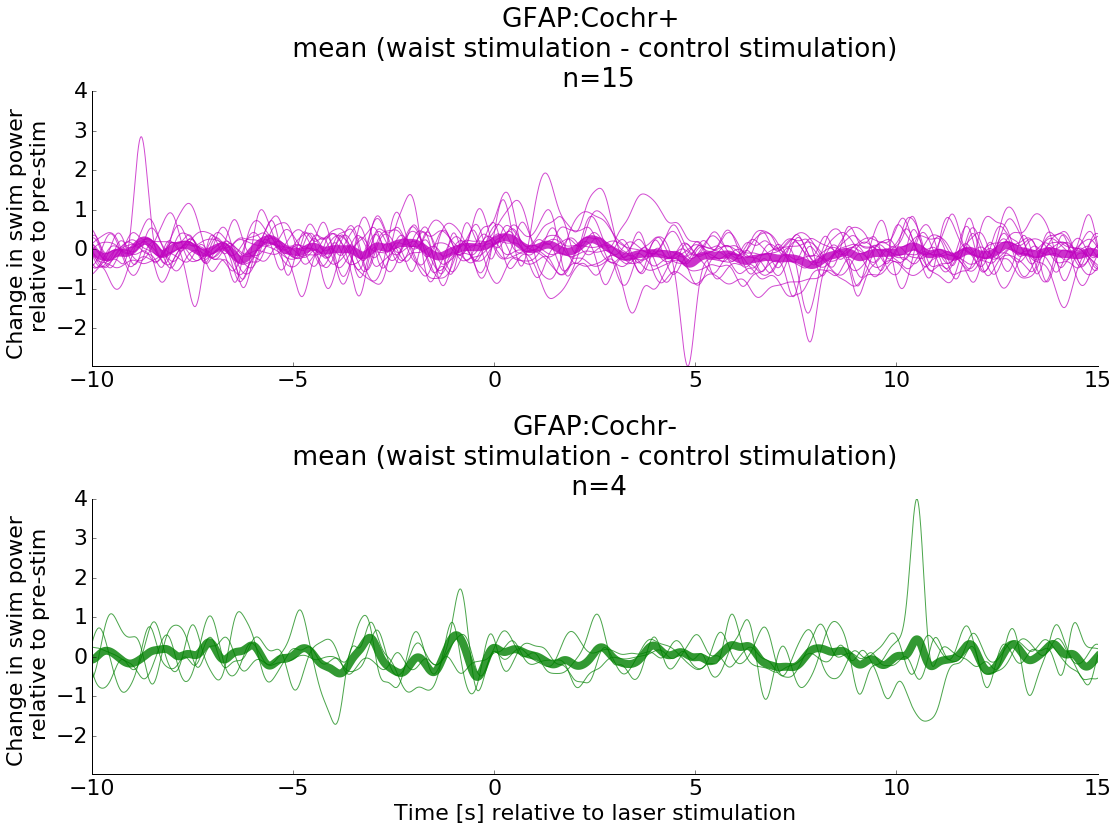

In [116]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
colors = ['m', 'k']
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16,12), sharey=True)
window_t = window / 6000

#rescale trial means
delta_pos = (rescaled_means['pos'][:,0,:] - rescaled_means['pos'][:,1,:]).T
delta_neg = (rescaled_means['neg'][:,0,:] - rescaled_means['neg'][:,1,:]).T

axs[0].plot(window_t, delta_pos, alpha=.7, color='m')
axs[0].plot(window_t, delta_pos.mean(1), color='m', linewidth=8, alpha=.8)
axs[0].axis('tight')
axs[0].title.set_text('GFAP:Cochr+ \n mean (waist stimulation - control stimulation) \n n={0}'.format(means['pos'].shape[0]))
axs[0].set_ylabel('Change in swim power \n relative to pre-stim')

axs[1].plot(window_t, delta_neg, alpha=.7, color='g')
axs[1].plot(window_t, delta_neg.mean(1), color='g', linewidth=8, alpha = .8)
axs[1].axis('tight')
axs[1].title.set_text('GFAP:Cochr-\n mean (waist stimulation - control stimulation) \n n={0}'.format(means['neg'].shape[0]))
axs[1].set_ylabel('Change in swim power \n relative to pre-stim')

axs[-1].set_xlabel('Time [s] relative to laser stimulation')
[axs_format(f) for f in axs]
plt.tight_layout()